<a href="https://colab.research.google.com/github/starirene9/DeepLearningAssignment/blob/main/Overfitting%26EarlyStopping%26DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.transforms as T
from torchvision.datasets import MNIST

In [35]:
def get_acc_loss(model, loader, loss_fn=None):
    model.eval()
    with torch.no_grad():
        loss = []
        total, correct = 0, 0
        for imgs, targets in loader:
            imgs = imgs.flatten(1).cuda()
            targets = targets.cuda()

            logits = model(imgs)

            if loss_fn:
                loss.append(float(loss_function(logits, targets).cpu()))

            _, preds = torch.max(logits.data, 1)

            """
            (values, indices) = (tensor([2.5, 4.2]), tensor([1, 2]))
            _, preds = torch.max(logits.data, 1)
            	•	preds에는 예측 클래스 번호만 저장하고 : tensor([1, 2])
	            •	앞에 있는 최댓값 자체는 _로 무시하는 거야.
            """

            total += targets.size(0) #total은 전체 이미지 개수를 누적하는 변수 → 평가 중인 모든 배치의 총 이미지 수를 계산
            correct += (preds == targets).sum().item() #.sum()은 맞은 개수를 더하고, .item()은 숫자만 꺼내는 함수야 (텐서를 정수로 바꿔줌).
        return 100 * correct / total, sum(loss) / max(len(loss), 1) #correct는 맞춘 정답 개수를 누적하는 변수

In [36]:
EPOCH = 200 # 반복횟수
BATCH_SIZE = 256 # 한 번에 넣을 데이터의 수

In [37]:
# 6만개 학습 데이터 중 일부만 사용 (80개)
data_set = [i for i in range(60000)]
random.shuffle(data_set)
data_set = data_set[:80] # 랜덤하게 뽑은 80 개 데이터의 인덱스 (데이터가 많은데 일부로 작은 데이터만 사용함 )

train = MNIST('./', train=True, download=True, transform=T.ToTensor())
test = MNIST('./', train=False, download=False, transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(data_set)) # SubsetRandomSampler : 주어진 인덱스의 데이터만 사용하게 돰
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, num_workers=3)

모델을 일부로 복잡하게 만들어 놓음

In [38]:
model = torch.nn.Sequential(torch.nn.Linear(28*28, 512+128), # 입력 그림 사이즈 이미지를 펼쳐서 784의 입력으로 만듦
                            torch.nn.ReLU(),
                            torch.nn.Linear(512+128, 512),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 256+128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256+128, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128+32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128+32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64+16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64+16, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 10),).cuda()

오버 피팅 발생

In [39]:
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []] #2차원 리스트(two-dimensional list)**를 두 개 만든 거
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda() #배치마다 이미지를 1차원으로 펼치는 코드
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        #마지막에 그래프 그릴 때, 훈련과 테스트를 비교해서 오버피팅 여부를 쉽게 보기 위해서
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 3.75 / 10.32 - loss: 2.3224985599517822 / 2.311453717947006
41 epoch - accuracy: 35.0 / 17.12 - loss: 1.8983519077301025 / 2.233211266994476
81 epoch - accuracy: 93.75 / 38.93 - loss: 0.3497479557991028 / 3.595288950204849
121 epoch - accuracy: 100.0 / 42.63 - loss: 0.006548973731696606 / 7.906347167491913
161 epoch - accuracy: 100.0 / 42.93 - loss: 0.001421748660504818 / 9.239647495746613


파랑색이 트레이닝, 주황색이 테스트 셋 : 오버피팅은 Loss를 기준으로 판단

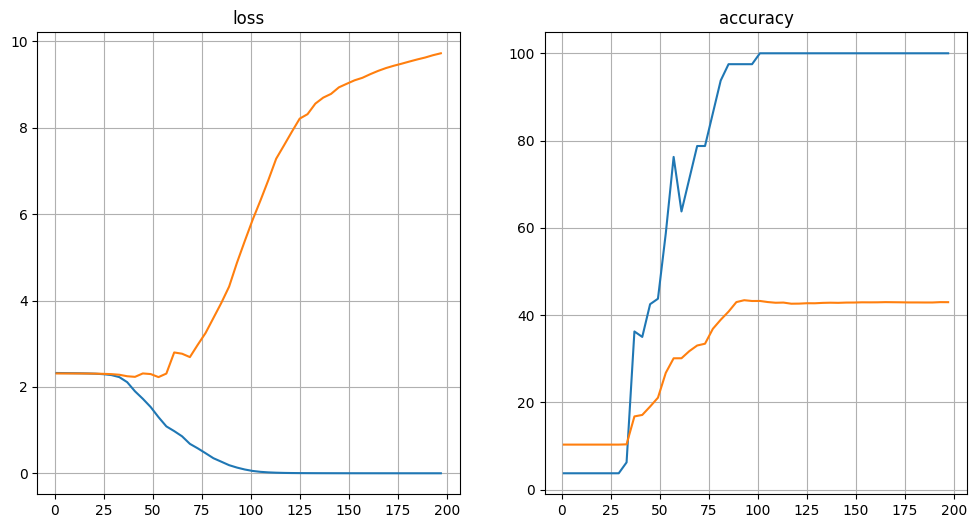

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0]) # range(start, stop, step)
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1]) # -> overfitting 발생 확인

#데이터의 양에 맞는 모델의 케파(크기)가 중요

In [41]:
## overfitting 방지 방법 1. 모델 설계
## overfitting 발생 원인을 고려하여 모델 재설계

# 지나친 축소는 지양하는게 좋음 : 2의 승수를 고집함
model = torch.nn.Sequential(
                            torch.nn.Linear(28*28, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 10)

).cuda()


state = {
    'model': model.state_dict(),
}
torch.save(state, 'model.pth')

In [42]:
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4: # 에폭이 4의 배수일 때만 실행
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40: # 에폭이 40의 배수일 때만 출력(print) 하겠다는 뜻
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 3.75 / 10.32 - loss: 2.3305070400238037 / 2.3052838921546934
41 epoch - accuracy: 18.75 / 11.25 - loss: 2.1399624347686768 / 2.24285569190979
81 epoch - accuracy: 70.0 / 35.52 - loss: 1.225356101989746 / 1.9654500544071198
121 epoch - accuracy: 97.5 / 46.96 - loss: 0.21246293187141418 / 2.188381612300873
161 epoch - accuracy: 100.0 / 48.87 - loss: 0.014910740777850151 / 3.213240694999695


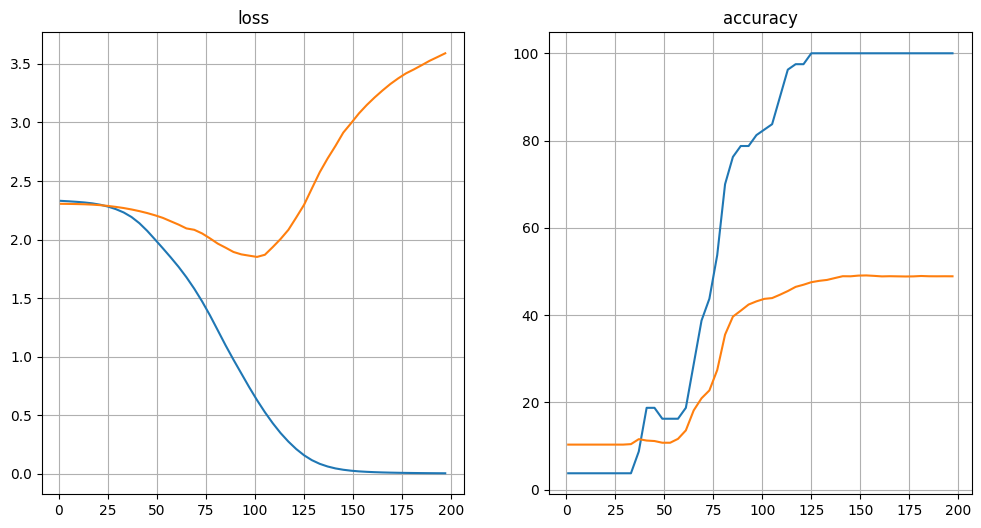

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1])

# **Early Stopping: 검증 데이터 필요**

In [44]:
## overfitting 방지 방법 2. early stopping
## early stopping을 위한 데이터셋 구성 (train set/ validation set / test set)

data_set = data_set[:80]
random.shuffle(data_set)

train_list = data_set[:64] # 64개
validation_list = data_set[64:80] # 80 - 64개

train = MNIST('./', train=True, download=True, transform=T.ToTensor())
test = MNIST('./', train=False, download=False, transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_list)) # SubsetRandomSampler : 주어진 인덱스의 데이터만 사용하게 돰
validation_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(validation_list))
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, num_workers=3)


In [45]:
# 저장된 모델 load - 동일한 weight로 실험을 진행하기 위해
model.load_state_dict(torch.load('model.pth')['model'])

loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)


# early stopping 설정
past_valid_loss = 99999999. #임의의 큰 초기값
patience = 0
max_patience = 3

for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()

    # 검증 loss 계산
    _, valid_loss = get_acc_loss(model, validation_loader, loss_function)

    # early stopping 로직
    if valid_loss >= past_valid_loss:
        patience += 1
        print(f"📉 validation loss 증가 → patience {patience}/{max_patience}")
    else:
        patience = 0

    # 조건 만족 시 중단
    if patience >= max_patience:
        print(f"🛑 Early stopping 발생 (epoch {epoch})")
        break

    past_valid_loss = valid_loss

📉 validation loss 증가 → patience 1/3
📉 validation loss 증가 → patience 2/3
📉 validation loss 증가 → patience 3/3
🛑 Early stopping 발생 (epoch 42)


In [46]:
train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
print(f'accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

accuracy: 15.625 / 10.45 - loss: 2.1048409938812256 / 2.274001568555832


# Data Augmentation : 데이터 증강
큰 변형보다 조그만한 변형이 좋음 (훼손하지 않는 정도로)

In [47]:
## overfitting 방지 방법 3. data augmentation
## Compose 안에 적용할 augmentation 방법 나열 (list)

train_transform = T.Compose([
    T.RandomCrop(size=28, padding=2),
    T.RandomPerspective(distortion_scale=0.1),
    T.RandomRotation(degrees=(-2,2)), # 작은 변화만 주는게 좋음
    T.ToTensor(),
])

train = MNIST('./', train=True, download=True, transform=train_transform) #transform=T.ToTensor()에서 변형 됨

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(data_set)) # 80개 데이터를 다시 사용하려고 함

In [48]:
model.load_state_dict(torch.load('model.pth')['model'])
"""
💡 실제로는 이런 상황에서 많이 써
	•	훈련을 중간에 끊고 다시 이어서 할 때
	•	여러 모델 실험을 할 때 동일한 시작점에서 비교하기 위해
	•	학습한 모델을 테스트 전용으로 불러올 때
"""
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

acc_lst, loss_lst = [[], []], [[], []]
for epoch in range(EPOCH):
    model.train()
    for img, target in train_loader:
        img = img.flatten(1).cuda()
        target = target.cuda()
        logit = model(img)

        optimizer.zero_grad()

        loss = loss_function(logit, target)

        loss.backward()
        optimizer.step()


    if not epoch % 4:
        train_acc, train_loss = get_acc_loss(model, train_loader, loss_function)
        test_acc, test_loss = get_acc_loss(model, test_loader, loss_function)
        acc_lst[0].append(train_acc)
        acc_lst[1].append(test_acc)
        loss_lst[0].append(train_loss)
        loss_lst[1].append(test_loss)
        if not epoch % 40:
            print(f'{epoch + 1} epoch - accuracy: {train_acc} / {test_acc} - loss: {train_loss} / {test_loss}')

1 epoch - accuracy: 3.75 / 10.32 - loss: 2.3308749198913574 / 2.305384707450867
41 epoch - accuracy: 16.25 / 10.54 - loss: 2.2250800132751465 / 2.3158758521080016
81 epoch - accuracy: 30.0 / 17.58 - loss: 1.9492788314819336 / 2.212793642282486
121 epoch - accuracy: 40.0 / 26.14 - loss: 1.5399216413497925 / 1.9826572597026826
161 epoch - accuracy: 58.75 / 40.5 - loss: 1.259909987449646 / 1.8724719554185867


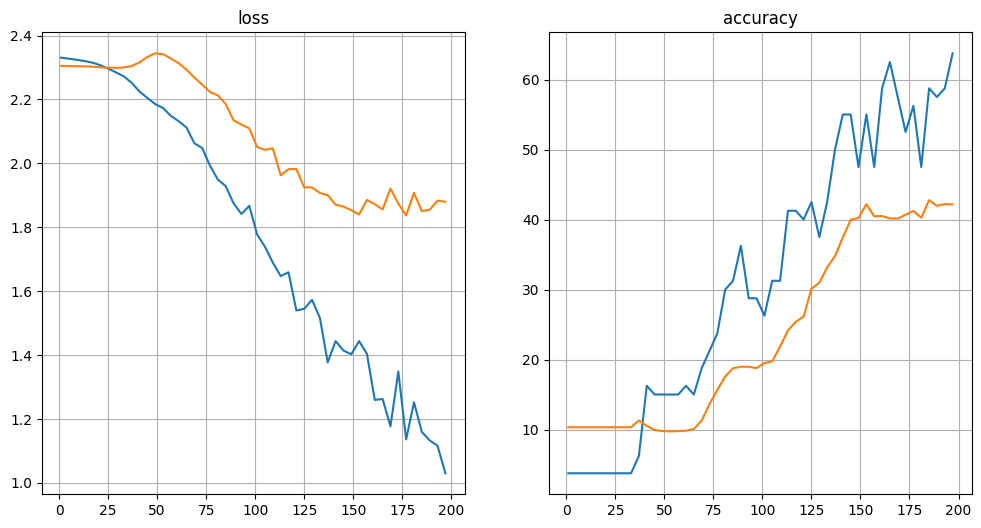

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss')
axes[0].grid()
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[0])
axes[0].plot([i for i in range(1, 200, 4)], loss_lst[1])

axes[1].set_title('accuracy')
axes[1].grid()
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[0])
axes[1].plot([i for i in range(1, 200, 4)], acc_lst[1])